In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

### Read the raw data

In [2]:
raw = pd.read_csv('casestudy.csv',index_col = 0)

In [3]:
raw.head()

,customer_email,net_revenue,year
0,nhknapwsbx@gmail.com,249.92,2015
1,joiuzbvcpn@gmail.com,87.61,2015
2,ukkjctepxt@gmail.com,168.38,2015
3,gykatilzrt@gmail.com,62.40,2015
4,mmsgsrtxah@gmail.com,43.08,2015


### expected data types are found

In [4]:
print(raw.shape)
print(raw.dtypes)

(685927, 3)
customer_email     object
net_revenue       float64
year                int64
dtype: object


In [5]:
raw.describe(include='all')

,customer_email,net_revenue,year
count,685927,685927.000000,685927.000000
unique,604618,NaN,NaN
top,ggzprdeier@gmail.com,NaN,NaN
freq,3,NaN,NaN
mean,NaN,125.647755,2016.027252
std,NaN,71.854528,0.837203
min,NaN,1.000000,2015.000000
25%,NaN,63.510000,2015.000000
50%,NaN,125.730000,2016.000000
75%,NaN,187.820000,2017.000000


### No missing values in the dataset

In [6]:
raw.isnull().mean()

customer_email    0.0
net_revenue       0.0
year              0.0
dtype: float64

### 1. total revenue for the current year

In [7]:
revenue_by_year = raw.groupby('year')[['net_revenue']].sum().reset_index()

In [8]:
revenue_by_year

,year,net_revenue
0,2015,29036749.19
1,2016,25730943.59
2,2017,31417495.03


In [9]:
for i in revenue_by_year.index:
     print(f'The revenue for {revenue_by_year.year[i]} is {revenue_by_year.net_revenue[0]}' )

The revenue for 2015 is 29036749.18999953
The revenue for 2016 is 29036749.18999953
The revenue for 2017 is 29036749.18999953


In [10]:
##using cross tab method
#pd.crosstab(raw.year,raw.net_revenue,values = raw.net_revenue,aggfunc='sum',margins='index')[['All']]

### 2.New Customer Revenue 

Logic: get new customers by removing all the email ids in current year which are also present in previous year

In [11]:
new_cust_a = pd.DataFrame(columns = ['year','net_revenue'])
for i in range(1,len(raw.year.unique())):
    cust_uniq_curyear = list(raw[raw['year']==raw.year.unique()[i]].customer_email.unique())
    cust_uniq_prevyear = list(raw[raw['year']==raw.year.unique()[i-1]].customer_email.unique())
    new_cust = list(set(cust_uniq_curyear)-set(cust_uniq_prevyear))
    new_cust_df = raw[(raw['year']==raw.year.unique()[i]) & (raw['customer_email'].isin(new_cust))]\
    .groupby('year')[['net_revenue']].sum().reset_index()
    print(f'The new customer revenue from year {raw.year.unique()[i]} is {new_cust_df.net_revenue[0]}' )
    new_cust_a = new_cust_a.append(new_cust_df,ignore_index=True)
new_cust_a.rename(columns = {'net_revenue':'new_cust_revenue'},inplace=True)

The new customer revenue from year 2016 is 18245491.010000203
The new customer revenue from year 2017 is 28776235.04


### 3.Existing Customer Growth

Logic: 
- existing customers are customers from last year who are also present in this year
- filter above customers in previous year to filter customers who continued till next year


In [12]:
growth_df_a = pd.DataFrame()
for i in range(1,len(raw.year.unique())):
    cust_uniq_prevyear = list(raw[raw['year']==raw.year.unique()[i-1]].customer_email.unique())
    exist_cust_curyear_df = raw[(raw['year']==raw.year.unique()[i])&(raw['customer_email'].isin(cust_uniq_prevyear))]
    rev_exist_cust_curyear = exist_cust_curyear_df.groupby('year')[['net_revenue']].sum().reset_index()

    exist_cust_prevyear_df = raw[(raw['year']==raw.year.unique()[i-1]) &(raw['customer_email'].\
                                                      isin(list(exist_cust_curyear_df.customer_email.unique()))) ]
    rev_exist_cust_prevyear = exist_cust_prevyear_df.groupby('year')[['net_revenue']].sum().reset_index()

    growth = rev_exist_cust_curyear['net_revenue'][0]-rev_exist_cust_prevyear['net_revenue'][0]
    growth_df = pd.DataFrame({'year':[raw.year.unique()[i]],'exist_cust_growth':[growth],\
                             'current_revenue_exist_cust':[rev_exist_cust_curyear['net_revenue'][0]],\
                              'prev_revenue_exist_cust':[rev_exist_cust_prevyear['net_revenue'][0]]})
    growth_df_a = growth_df_a.append(growth_df,ignore_index=True)
    print(f'The existing customer growth from {raw.year.unique()[i-1]} to {raw.year.unique()[i]} is {growth}' )


The existing customer growth from 2015 to 2016 is 20335.4599999981
The existing customer growth from 2016 to 2017 is 20611.340000017546


### 4.Revenue lost from attrition
Logic
- Total revenue of customers from previous year who didn't continue in current year

In [13]:
lost_cust_a = pd.DataFrame(columns = ['year','net_revenue'])
for i in range(1,len(raw.year.unique())):
    cust_uniq_curyear = list(raw[raw['year']==raw.year.unique()[i]].customer_email.unique())
    cust_uniq_prevyear = list(raw[raw['year']==raw.year.unique()[i-1]].customer_email.unique())
    lost_cust = list(set(cust_uniq_prevyear)-set(cust_uniq_curyear))
    lost_cust_df = raw[(raw['year']==raw.year.unique()[i-1]) & (raw['customer_email'].isin(lost_cust))]\
    .groupby('year')[['net_revenue']].sum().reset_index()
    lost_cust_df.iloc[0,0] = lost_cust_df.iloc[0,0]+1
    print(f'Revenue lost from attrition in year {raw.year.unique()[i]} is {lost_cust_df.net_revenue[0]}' )
    lost_cust_a = lost_cust_a.append(lost_cust_df,ignore_index=True)
lost_cust_a.rename(columns = {'net_revenue':'lost_cust_revenue'},inplace=True)


Revenue lost from attrition in year 2016 is 21571632.069999415
Revenue lost from attrition in year 2017 is 23110294.939999864


### 5.Existing Customer Revenue Current Year & 6.Existing Customer Revenue Prior Year

Logic
- revenue of customers in current year who continued from past year

In [14]:
for i in range(1,len(raw.year.unique())):
    cust_uniq_prevyear = list(raw[raw['year']==raw.year.unique()[i-1]].customer_email.unique())
    exist_cust_curyear_df = raw[(raw['year']==raw.year.unique()[i])&(raw['customer_email'].isin(cust_uniq_prevyear))]
    rev_exist_cust_curyear = exist_cust_curyear_df.groupby('year')[['net_revenue']].sum().reset_index()

    exist_cust_prevyear_df = raw[(raw['year']==raw.year.unique()[i-1]) &(raw['customer_email'].\
                                                      isin(list(exist_cust_curyear_df.customer_email.unique()))) ]
    rev_exist_cust_prevyear = exist_cust_prevyear_df.groupby('year')[['net_revenue']].sum().reset_index()

    growth = rev_exist_cust_curyear['net_revenue'][0]-rev_exist_cust_prevyear['net_revenue'][0]
    print(f"The existing customer revenue in current year {raw.year.unique()[i]}  is {rev_exist_cust_curyear['net_revenue'][0]}")
    print(f"The existing customer revenue in previous year {raw.year.unique()[i-1]}  is {rev_exist_cust_prevyear['net_revenue'][0]}" )

The existing customer revenue in current year 2016  is 7485452.5800000075
The existing customer revenue in previous year 2015  is 7465117.120000009
The existing customer revenue in current year 2017  is 2641259.990000008
The existing customer revenue in previous year 2016  is 2620648.6499999906


### 7.Total Customers Current Year
- Number of customers in each year are unique

In [15]:
raw.groupby(['year']).agg({'year':'count','customer_email':'count'})

,year,customer_email
year,,
2015,231294,231294
2016,204646,204646
2017,249987,249987


In [16]:
total_cust = raw.groupby(['year'])[['customer_email']].count().reset_index()
total_cust.rename({'customer_email':'total_customers'},inplace = True)
for i in range(len(total_cust)):
    print(f'Total customers in {total_cust.iloc[i,0]} is {total_cust.iloc[i,1]}')

Total customers in 2015 is 231294
Total customers in 2016 is 204646
Total customers in 2017 is 249987


### 8.Total customers previous year

In [17]:
total_cust = raw.groupby(['year'])[['customer_email']].count().reset_index()
for i in range(1,len(total_cust)):
    print(f'Total customers in {total_cust.iloc[i-1,0]} which is previous year to {total_cust.iloc[i,0]} is {total_cust.iloc[i-1,1]}')

Total customers in 2015 which is previous year to 2016 is 231294
Total customers in 2016 which is previous year to 2017 is 204646


### 9.New customers

In [18]:
new_cust_count_a = pd.DataFrame(columns = ['year','new_customers'])
for i in range(1,len(raw.year.unique())):
    cust_uniq_curyear = list(raw[raw['year']==raw.year.unique()[i]].customer_email.unique())
    cust_uniq_prevyear = list(raw[raw['year']==raw.year.unique()[i-1]].customer_email.unique())
    new_cust = len(list(set(cust_uniq_curyear)-set(cust_uniq_prevyear)))
    new_cust_df = pd.DataFrame({'year':[raw.year.unique()[i]],'new_customers':[new_cust]})
    print(f'The new customers in year {raw.year.unique()[i]} is {new_cust}' )
    new_cust_count_a = new_cust_count_a.append(new_cust_df,ignore_index=True)

The new customers in year 2016 is 145062
The new customers in year 2017 is 229028


### 10.Lost Customers

In [19]:
lost_cust_count_a = pd.DataFrame(columns = ['year','lost_customers'])
for i in range(1,len(raw.year.unique())):
    cust_uniq_curyear = list(raw[raw['year']==raw.year.unique()[i]].customer_email.unique())
    cust_uniq_prevyear = list(raw[raw['year']==raw.year.unique()[i-1]].customer_email.unique())
    lost_cust = len(list(set(cust_uniq_prevyear)-set(cust_uniq_curyear)))
    lost_cust_df = pd.DataFrame({'year':[raw.year.unique()[i]],'lost_customers':[lost_cust]})
    print(f'The lost customers in year {raw.year.unique()[i]} is {new_cust}' )
    lost_cust_count_a = lost_cust_count_a.append(lost_cust_df,ignore_index=True)

The lost customers in year 2016 is 229028
The lost customers in year 2017 is 229028


### Visualizations

In [24]:
# revenue_by_year
# new_cust_a
# lost_cust_a
# total_cust
# new_cust_count_a
# lost_cust_count_a
year = pd.DataFrame({'year':[2015,2016,2017]})
summ = year.merge(revenue_by_year,on='year',how = 'left').\
            merge(new_cust_a,on='year',how = 'left').\
            merge(growth_df_a,on='year',how = 'left').\
            merge(lost_cust_a,on='year',how = 'left').\
            merge(total_cust,on='year',how = 'left').\
            merge(new_cust_count_a,on='year',how = 'left').\
            merge(lost_cust_count_a,on='year',how = 'left')



In [23]:
summ.to_csv('summ.csv')

In [25]:
summ

,year,net_revenue,new_cust_revenue,exist_cust_growth,current_revenue_exist_cust,prev_revenue_exist_cust,lost_cust_revenue,customer_email,new_customers,lost_customers
0,2015,29036749.19,NaN,NaN,NaN,NaN,NaN,231294,NaN,NaN
1,2016,25730943.59,18245491.01,20335.46,7485452.58,7465117.12,2.157163e+07,204646,145062,171710
2,2017,31417495.03,28776235.04,20611.34,2641259.99,2620648.65,2.311029e+07,249987,229028,183687


<AxesSubplot:xlabel='year', ylabel='net_revenue'>

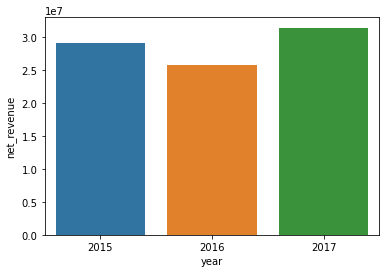

In [39]:
sns.barplot(data=summ,x='year',y='net_revenue')

In [41]:
import os

os.system('jupyter nbconvert --to html casestudy.ipynb')

0